By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook discusses feature interpretation in the context of ANTIPASTI.

In [1]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import compute_change_in_kd, get_epsilon, get_maps_of_interest, map_residues_to_regions, plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading results

In [2]:
# Parameters
modes = 30
n_filters = 3
filter_size = 5
pooling_size = 2
n_max_epochs = 159

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
stage = 'predicting'
regions = 'paired_hl'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'

# Pre-processing
preprocessed_data = Preprocessing(modes=modes, pathological=pathological, regions=regions, mode=mode, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path)
input_shape = preprocessed_data.test_x.shape[-1]

# Loading the actual checkpoint and learnt filters
path = '../checkpoints/model_' + regions + '_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
learnt_filter = np.load('../checkpoints/learnt_filter_'+regions+'_epochs_'+str(n_max_epochs)+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy')
model.eval()

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropit): Dropout(p=0.05, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=33075, out_features=1, bias=False)
)

# Obtaining maps of interest

In [3]:
mean_learnt, mean_image, mean_diff_image = get_maps_of_interest(preprocessed_data, learnt_filter)

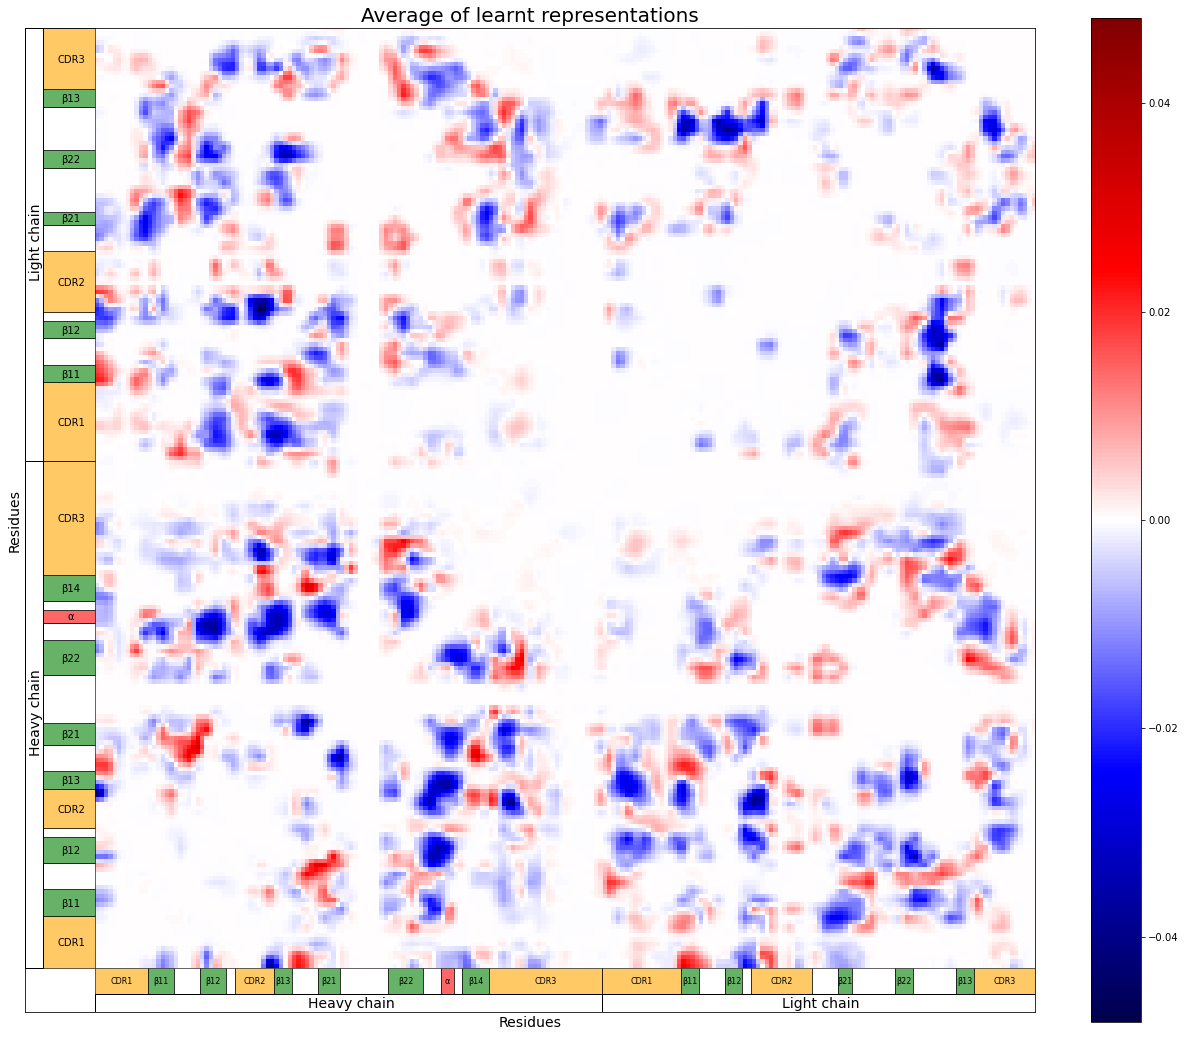

In [4]:
plot_map_with_regions(preprocessed_data, mean_learnt, 'Average of learnt representations')

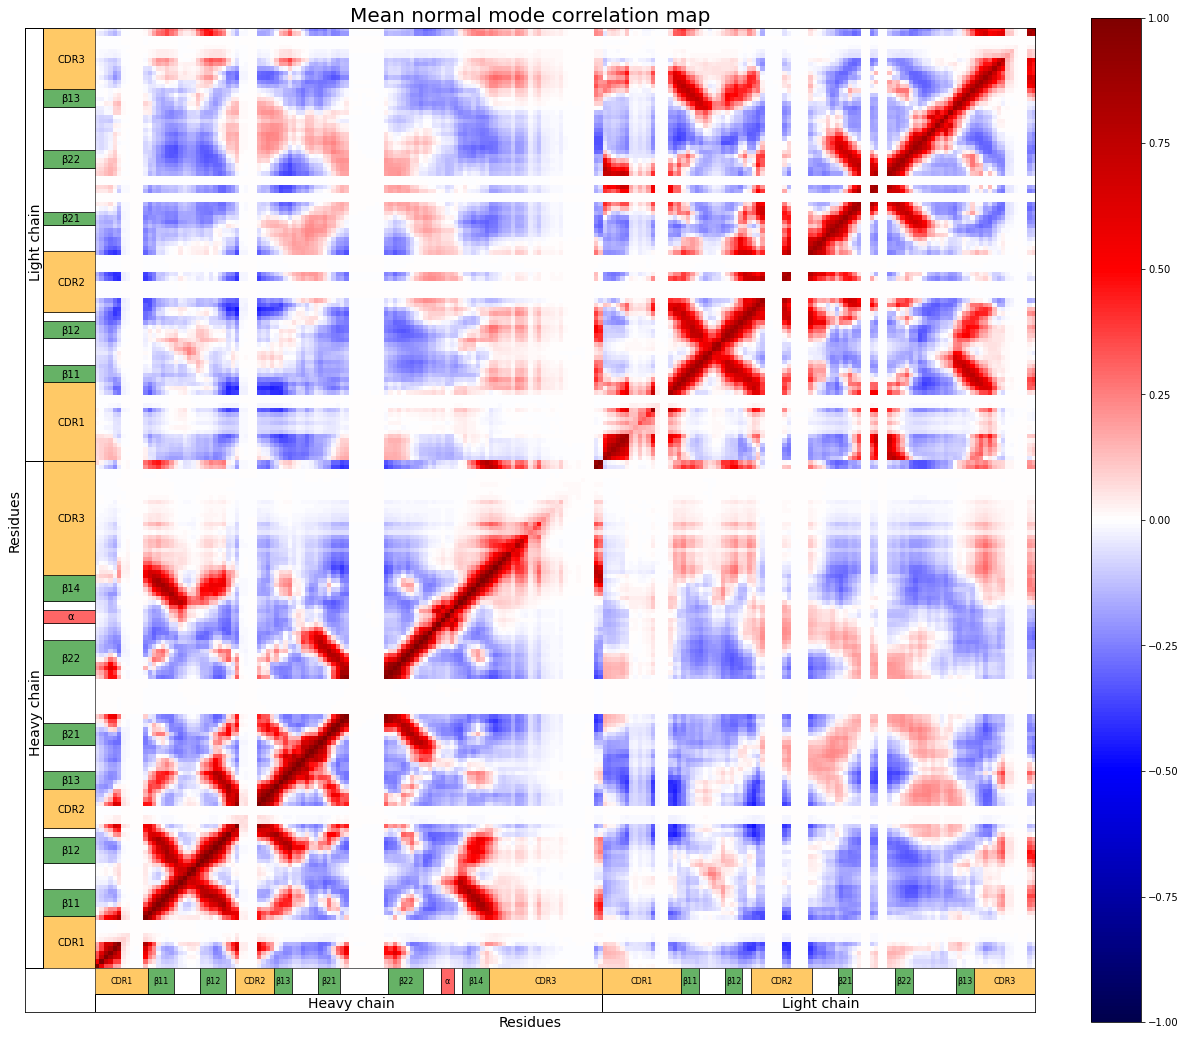

In [5]:
plot_map_with_regions(preprocessed_data, mean_image, 'Mean normal mode correlation map')

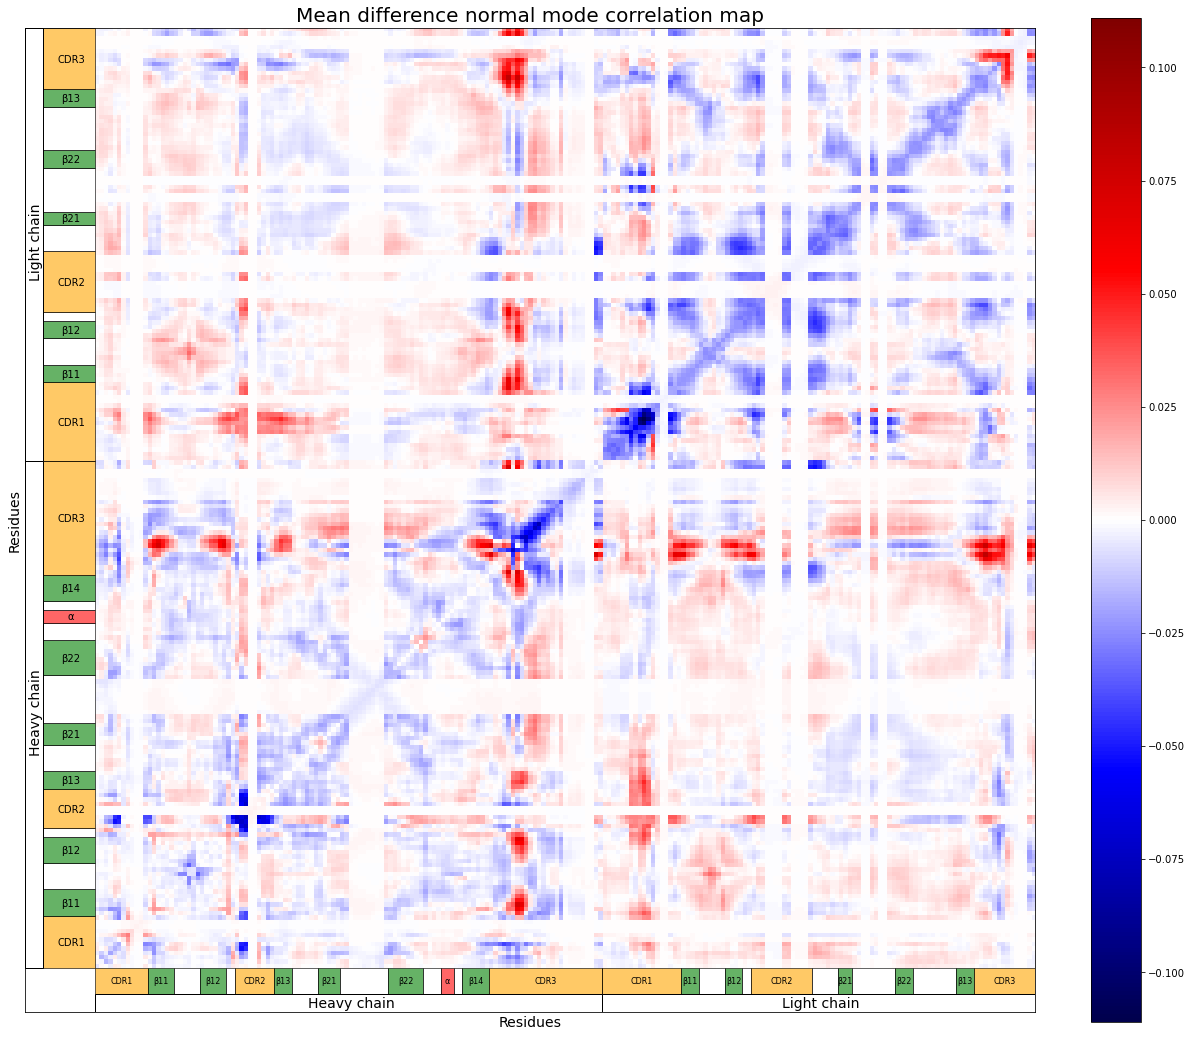

In [6]:
plot_map_with_regions(preprocessed_data, mean_diff_image, 'Mean difference normal mode correlation map')

# Obtaining $\epsilon$

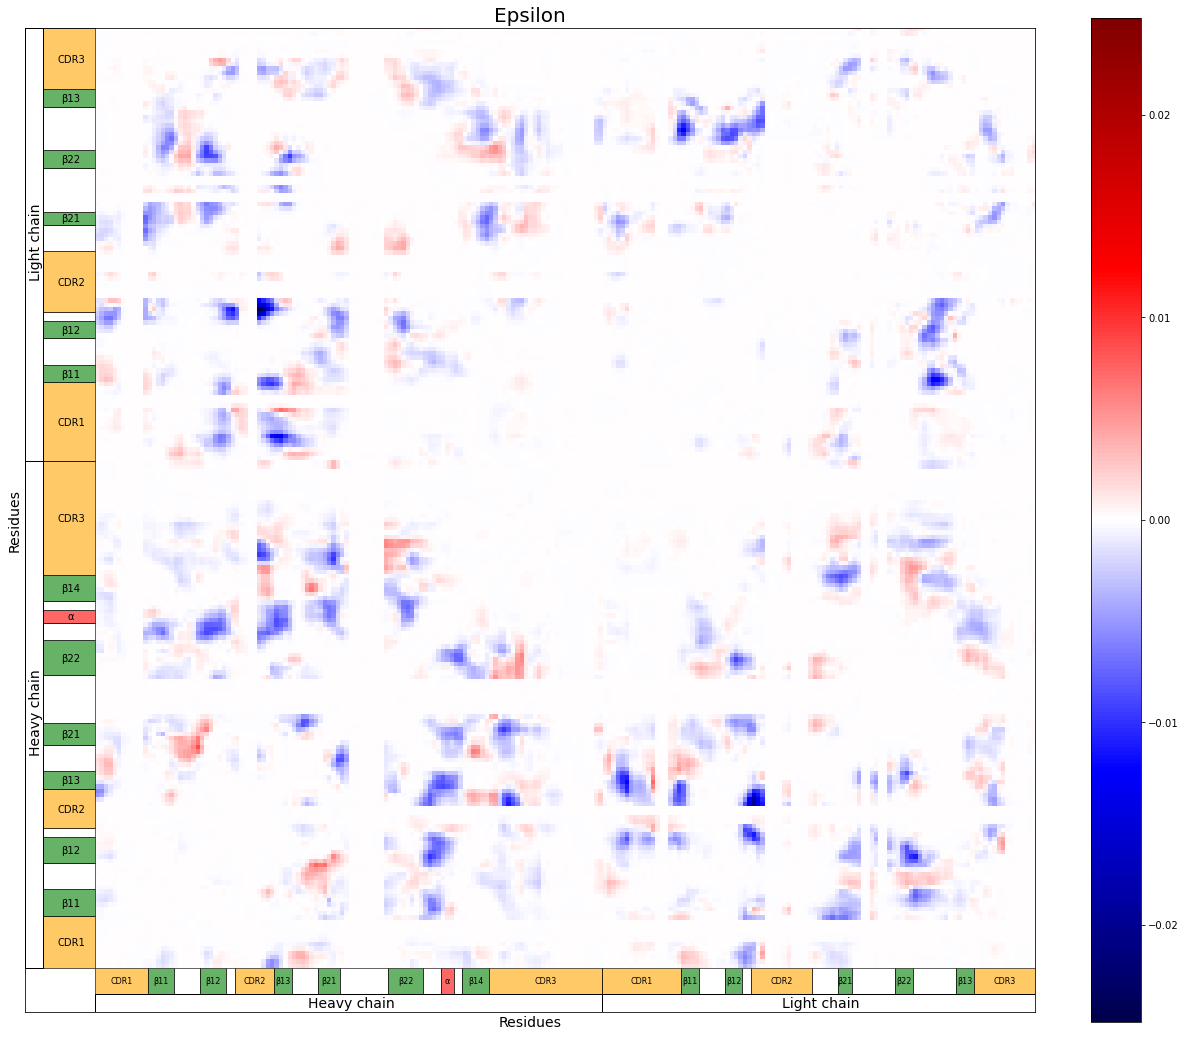

In [7]:
epsilon = get_epsilon(preprocessed_data, model, mean_diff_image)

plot_map_with_regions(preprocessed_data, epsilon, 'Epsilon')

# Change in $K_D$ when adding $\epsilon$

In [8]:
coord, maps, labels = map_residues_to_regions(preprocessed_data, epsilon)

In [9]:
# Here it is possible to tune the weight of each antibody region

# Heavy chain
cdr1_factor_h = 0.1
beta11_factor_h = 0.1 
beta12_factor_h = 0.1 
cdr2_factor_h = 0.1 
beta13_factor_h = 0.1 
beta21_factor_h = 0.1 
beta22_factor_h = 0.1 
alpha_factor_h = 0.1 
beta14_factor_h = 0.1 
cdr3_factor_h = 0.1 

# Light chain
cdr1_factor_l = 0.1 
beta11_factor_l = 0.1 
beta12_factor_l = 0.1 
cdr2_factor_l = 0.1 
beta21_factor_l = 0.1 
beta22_factor_l = 0.1 
beta13_factor_l = 0.1 
cdr3_factor_l = 0.1 

# Expressing weights as vector
weights_h = [cdr1_factor_h, beta11_factor_h, 0.1, beta12_factor_h, 0.1, cdr2_factor_h, beta13_factor_h, 0.1, 
             beta21_factor_h, 0.1, beta22_factor_h, 0.1, alpha_factor_h, 0.1, beta14_factor_h, cdr3_factor_h]
weights_l = [cdr1_factor_l, beta11_factor_l, 0.1, beta12_factor_l, 0.1, cdr2_factor_l, 0.1, beta21_factor_l, 
             0.1, beta22_factor_l, 0.1, beta13_factor_l, cdr3_factor_l]
weights = np.array(weights_h + weights_l)

compute_change_in_kd(preprocessed_data, model, weights, coord, maps)

Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.5555827e-07
Thus, Kd is smaller by 9.536604 %


In [10]:
importance_matrix_signed = np.zeros((len(coord), len(coord)))
for j,_map in enumerate(maps):
    for i in range(len(coord)):
        importance_matrix_signed[i,j] = _map[coord[i],:].sum()

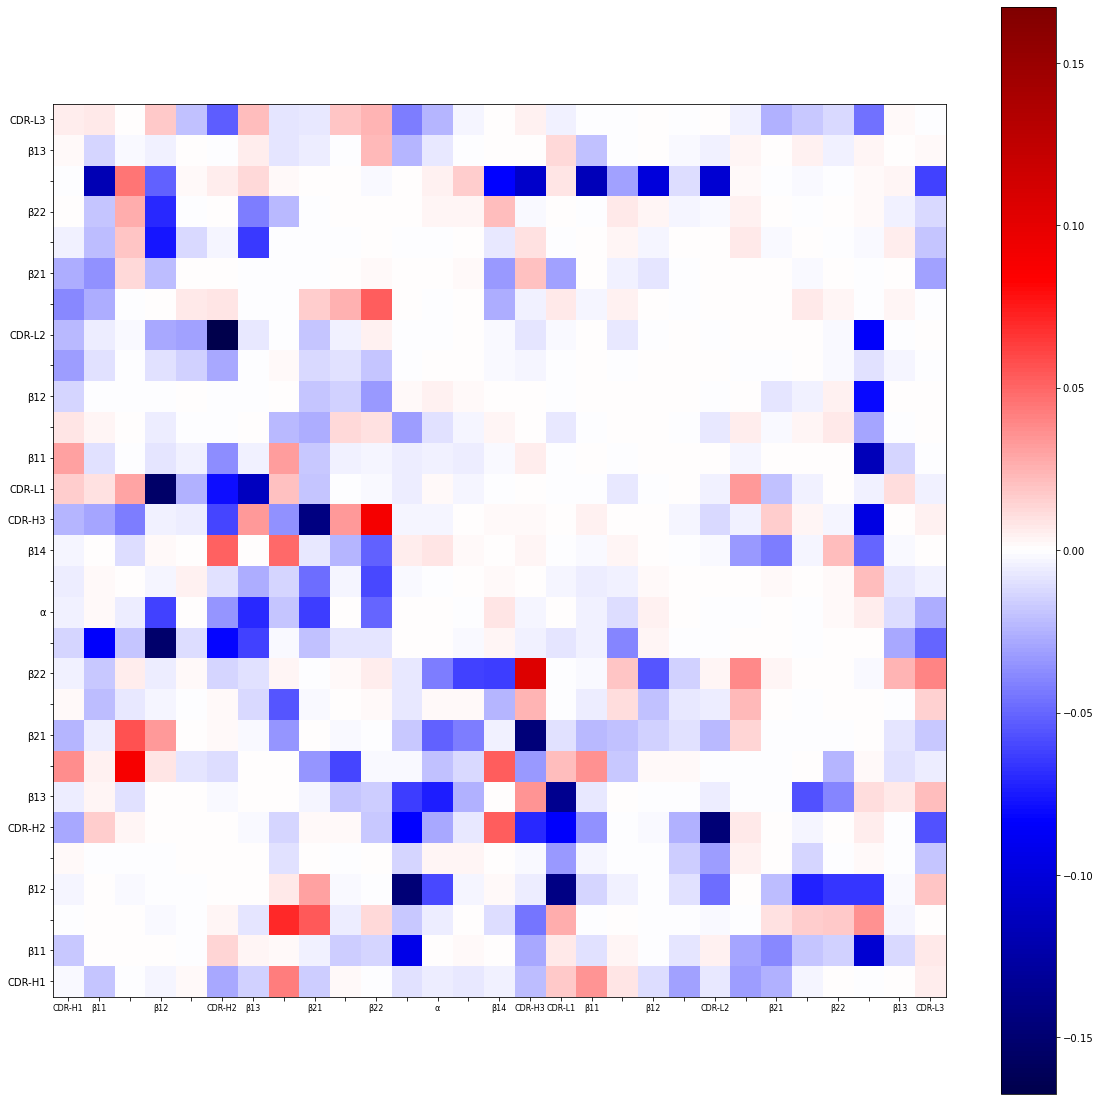

In [11]:
fig = plt.figure(figsize=(20, 20))
plt.imshow(importance_matrix_signed, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.xticks(np.arange(len(coord)), labels, size=8)
plt.yticks(np.arange(len(coord)), labels)
plt.colorbar()
plt.show()

In [12]:
importance_matrix = np.abs(importance_matrix_signed)

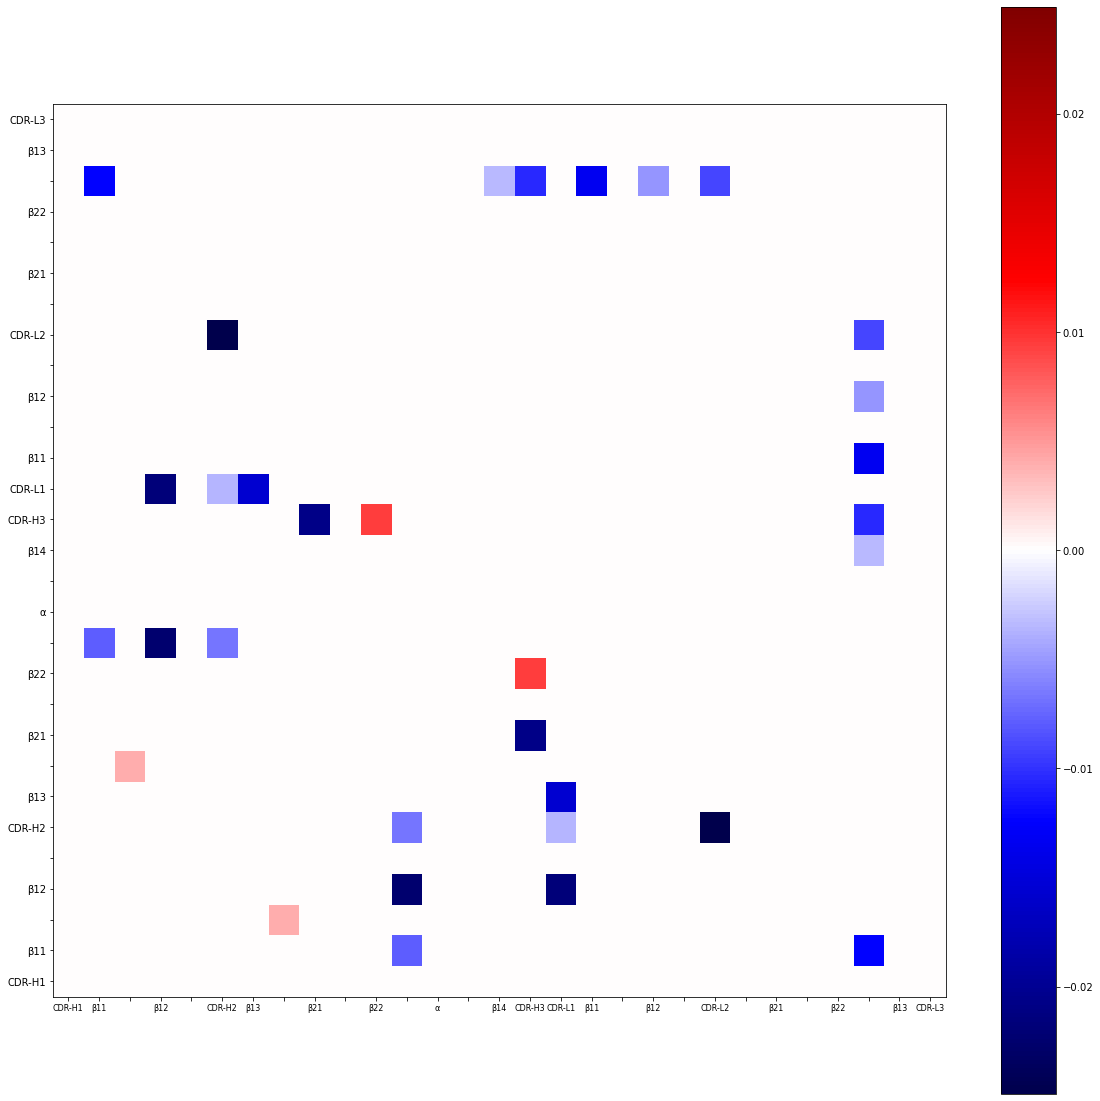

In [13]:
im = np.multiply(np.where(importance_matrix<0.08, 0, importance_matrix), importance_matrix_signed)

fig = plt.figure(figsize=(20, 20))
plt.imshow((im + np.transpose(im))/2, origin='lower', cmap='seismic', norm=CenteredNorm())
plt.xticks(np.arange(len(coord)), labels, size=8)
plt.yticks(np.arange(len(coord)), labels)
plt.colorbar()
plt.show()

## One region at a time

In [16]:
for i in range(len(coord)):
    weights_at_a_time = np.zeros((len(coord)))
    weights_at_a_time[i] = 0.1
    print('---------------------------------------------')
    print(labels[i])
    compute_change_in_kd(preprocessed_data, model, weights_at_a_time, coord, maps)

---------------------------------------------
CDR-H1
Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.7157016e-07
Thus, Kd is smaller by 0.22504199 %
---------------------------------------------
β11
Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.7141878e-07
Thus, Kd is smaller by 0.31308037 %
---------------------------------------------

Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.7147676e-07
Thus, Kd is smaller by 0.27936247 %
---------------------------------------------
β12
Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.7080555e-07
Thus, Kd is smaller by 0.6696964 %
---------------------------------------------

Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.7159974e-07
Thus, Kd is smaller by 0.20784424 %
---------------------------------------------
CDR-H2
Without adding epsilon, Kd = 1.7195714e-07
After adding epsilon, Kd = 1.7024199e-07
Thus, Kd is small

In [15]:
# Ranking: CDR-H2 (1.1%), CDR-L1 (0.78%), Hβ12 (0.68%), Empty betwHβ22-α (0.66%), Empty betwHβ13-Hβ21 (0.6%)
# Hβ21 (0.58%), Hβ13 (0.58%)
#
# Until here more than half of the contributions (7 of 29 'structures')
#
# Hβ22 (0.48%), α (0.43%), CDR-H3 (0.36%), Emtpy betwLβ22-Lβ13 (0.33%), Hβ14 (0.32%), etc...